In [1]:
import pyAudioKits.audio as ak
import numpy as np
import pyAudioKits.analyse as aly
import pyAudioKits.algorithm as alg

After the introduction of general audio, this section further begins the study of speech signals. Both the theory and the analysis methods of general audio are applicable to the speech signal, which in turn has more further properties and analysis methods, as well as some specific tasks.

# Composition of speech

The speech signal is composed of three components.

1. Voiced sound: periodic or quasi-periodic in nature, its frequency is called fundamental frequency ($F_0$). Nearly musical tone.

2. Unvoiced sound: no periodicity, no fixed pitch. Approximates noise.

3. Silence: there is still background noise.

The three components here are mutually exclusive in time, so the speech signal can be sliced and categorized into the three categories mentioned above.

# Modeling of speech

The speech is generated by the linear time-invariant system mentioned in the previous section, namely $Y(z)=H(z)X(z)$, where $y$ is the generated speech, $x$ is the **excitation** needed to generate the speech, and $h$ is the system **formed by our vocal tract and lips**.

Voiced sound is produced by forcing air through the **glottis**, in which case **glottis vibrates**, producing **quasi periodic airflow** to stimulate the vocal tract. This kind of excitation has fundamental wave and multiple harmonics, which is similar to musical tones. Unvoiced sound is produced by forming a contraction along a certain point of the vocal tract, forcing the air to produce **turbulence** through contraction. The excitation of voiced and unvoiced tones is random, so they belong to random signals.

The specific pronunciation is determined by the **vocal tract resonance**, which is excited by the glottic energy. The vocal tract can be regarded as a straight tube with uniform cross-sectional area, which closes at the glottic end and opens at the lip. When the shape of the vocal tract changes, the resonance also changes. Generally, there are two **formants**, which are the characteristics of **pronunciation**.

For voiced sound, the glottis is modeled as a bipolar system, **the air excitation convolutes with the bipolar system to produce the excitation of voiced sound**; unvoiced sound does not pass through glottis, **turbulence is directly used as excitation**.

The actions of glottis, vocal tract and lips will change the position of the zero point and pole of the system over time, change the characteristics of pronunciation over time, and enable speech to transmit information. Therefore, speech signals often do not satisfy the stationary stochastic process.

# Properties of speech

Speech is also an audio signal, so energy, power, autocorrelation function, spectrum, power spectral density and other attributes are applicable to speech. Since the speech signal is often not stationary, framing and windowing must be performed before speech signal analysis.

In addition, speech signal has two attributes **zero crossing rate** and **spectral entropy**, which are defined in time domain and frequency domain respectively. The zero crossing rate is the frequency at which the audio intensity curve passes through 0, which can reflect the frequency of those components with the greatest intensity in the signal; The spectral entropy represents the amount of information of a short-term signal. The larger the spectral entropy, the smaller the amount of information.

For speech signal analysis, we first record a short segment of audio. The audio used in the demonstration is "sample_audio/zero_to_nine(Chinese).Wav", which is the Chinese pronunciation of nine Arabic numerals from 0 to 9.

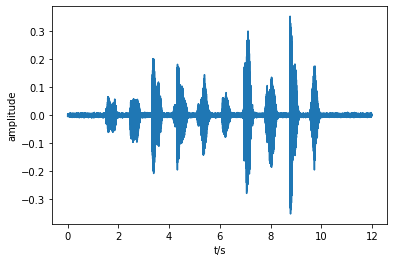

<Figure size 432x288 with 0 Axes>

In [2]:
record = ak.read_Audio("sample_audio/zero_to_nine(Chinese).wav")
record.plot()

It can be seen that the amplitude of the signal concentrated at 10 positions is significantly greater than 0, which is the position where there is voice, and the other positions are silent.

In [3]:
record.sound()

The power of the audio:  0.0008365712991196913


Among them, there are unvoiced sound at the beginning of "three", "four", "seven" and "Nine", and the rest are voiced sound.

To analyze the audio signal, we need to perform framing and windowing. Here we use Hamming window.

In [4]:
record_framed = record.framing(window="hamming")

The recorded sampling rate is 44100Hz, while the fundamental frequency of human voice is generally distributed between 100-500hz. When drawing spectrogram, we need to compress the resolution of high frequency and improve the resolution of low frequency. The method is to use mel scale frequency axis coordinates. The theoretical basis of mel scale is that the sound frequency perceived by human ear is not linearly related to the actual frequency of sound. Mel scale gives the frequency range a resolution equivalent to human auditory resolution. The formula for converting from real frequency $f$to Mel frequency is $f_ {mel}=2595\log_ {10}(1+f/700)$.

In addition, we also use the form of gain for the rendering of speech amplitude spectrogram.

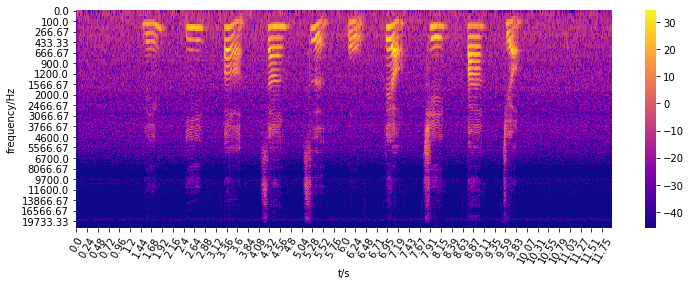

<Figure size 432x288 with 0 Axes>

In [5]:
aly.FFT(record_framed).plot(plot_type="dB",freq_scale="mel")

The spectrogram of voiced part presents horizontal stripes stacked vertically, and the higher the frequency, the colder the color of stripes, indicating that the intensity is lower. This shows that voiced sound is the superposition of fundamental wave and harmonics, and its fundamental wave determines its pitch.

The unvoiced part is a single longitudinal stripe, and its frequency components are distributed in the whole frequency range, so it is similar to white noise.

There is still noise in the mute part, and these noise frequency components are mainly concentrated in the low-frequency part.

Statistic the short-time spectral entropy, which is calculated as $H[k]=\displaystyle-\sum_{m=k-N+1}^{N/2}p[k,m]\log_2p[k,m]w[n-m]$, where $p[k,m]=\frac{\displaystyle Y[k,n]}{\displaystyle\sum_{l=0}^{\frac{N}{2}}Y[k,l]}$, $Y[k,n]=X[k,n]X^*[k,n]$, and $X[k,n]$ is the short-time spectrum of the $k$ th frame.

/Users/harmonialeo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


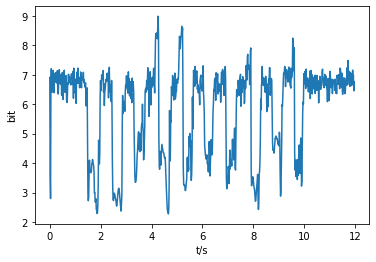

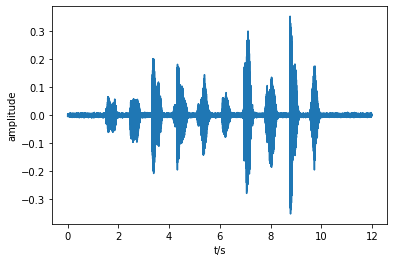

(None, None)

<Figure size 432x288 with 0 Axes>

In [6]:
aly.specEntropy(record_framed).plot(), record.plot()

The spectral entropy of silence is medium, of unvoiced sound is the largest, and of voiced sound is the smallest. 

Statistic the Short-term zero crossing rate.

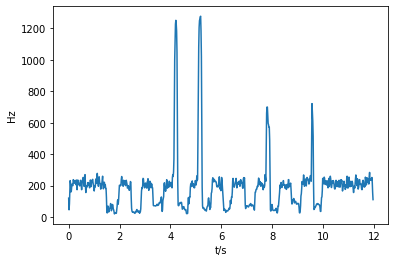

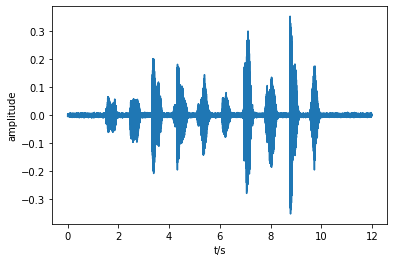

(None, None)

<Figure size 432x288 with 0 Axes>

In [8]:
aly.zerocrossing(record_framed).plot(), record.plot()

The zero crossing rate of silence is medium, of unvoiced sound is the largest, and of voiced sound is the smallest.

Then carry out the statistics of short-term energy.

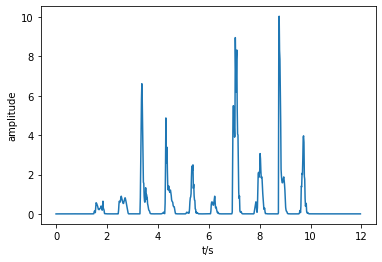

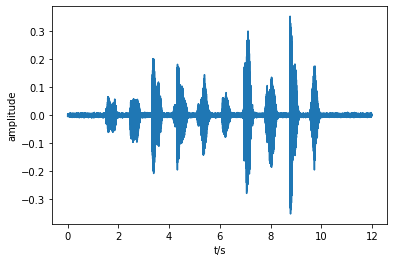

(None, None)

<Figure size 432x288 with 0 Axes>

In [9]:
aly.energy(record_framed).plot(), record.plot()

The energy of silence is almost zero, while voiced and unvoiced sounds have higher energy.

# Endpoint detection of speech

Given that there is a statistically significant difference between the silent part and the speech part, as well as between the unvoiced part and the voiced part, in terms of properties such as short-time energy, short-time zero crossing rate and spectral entropy, we can leverage this distinction to perform **endpoint detection** on speech. The goal of endpoint detection is to detect the start and end points of each segment of speech in an audio signal and to distinguish between voiced and unvoiced sounds.

A common method for endpoint detection is the double threshold method.

1. Calculate **short-time energy and short-time zero crossing rate**.

2. Set a **short-time energy threshold** and a **short-time zero crossing rate threshold**.
3. Calculate the point that the short-time energy **crosses the short-time energy threshold up as the speech start point** and the point **that crosses the short-time energy threshold down as the speech end point**.
4. Starting from the **speech start point to the left**, find the last point where the **short-time zero crossing rate is greater than the short-time zero crossing rate threshold** as the new speech start point; starting from the **speech end point to the right**, find the first point where the **short-time zero crossing rate is greater than the short-time over-zero rate threshold** as the new voice end point. This will distinguish between **speech and silent**.
5. Set another **higher short-time energy threshold** within the speech segment.
6. Within each speech segment, calculate the short-time energy **the point that goes up through the short-time energy threshold as the voiced sound start point** and **the point that goes down through the short-time energy threshold as the voiced sound end point**.
7. Starting from the **voiced sound start point to the left**, find the last point where the **short-time zero crossing rate is less than the short-time zero crossing rate threshold** as the new voiced sound start point; starting from the **voiced sound end point to the right**, find the first point where the **short-time zero crossing rate is less than the short-time zero crossing rate threshold** as the new voiced sound end point. In this way, it is possible to distinguish between **voiced and unvoiced sounds**.

<AxesSubplot:>

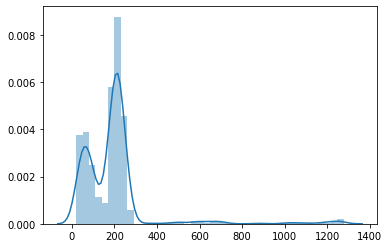

In [11]:
import seaborn as sns

sns.distplot(aly.zerocrossing(record_framed).samples)

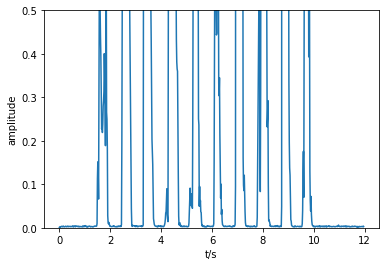

<Figure size 432x288 with 0 Axes>

In [12]:
aly.energy(record_framed).plot(ylim=(0,0.5))

Plotting the histogram of the short-time zero crossing rate can help us to select the threshold. The short-time energy threshold is determined by observing the short-time energy image and then continuously adjust.

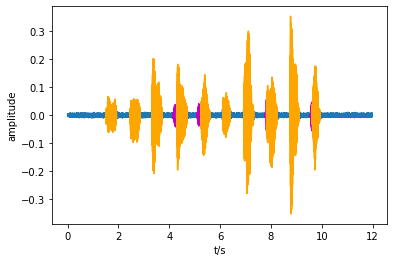

<Figure size 432x288 with 0 Axes>

In [13]:
vad_result = alg.VAD(record, 0.05, 0.5, 400)    #Endpoint detection for the recording, setting a lower short-time energy threshold of 0.05, a higher short-time energy threshold of 0.5, and a short-time over-zero rate threshold of 400
vad_result.plot()

It can be seen that we have successfully distinguished 10 segments of speech, and we have distinguished the unvoiced sounds before "three", "four", "seven" and "nine".

# Speech Recognition

Speech recognition is one of the tasks in speech signal processing. The most basic supervised speech recognition requires a training set containing the features of many segments of speech and their corresponding text labels for training the model. For a newly obtained speech, we want the machine to recognize the text corresponding to that speech, so the newly obtained speech is used as a test set, the features are extracted and passed through the model to get the labels so that the text corresponding to the speech on the test set is known. 

## MFCC

In order to be able to perform speech recognition, speech features need to be extracted first. The speech spectrum is one of the available speech features. If the Fourier transform is performed using all the sample points in each frame, the spectrum contains all the information of the speech. However, the speech spectrum is very large. For a speech signal with K frames and N sample points in each frame, if $N$-point Fourier transform is used, the size of the speech spectrum is $K\times \frac{N}{2}$, which is equal to half of the total number of samples if the overlap rate of frames is 0. If the algorithm we use for speech recognition is simple, we can extract some features that are lighter but maintain the maximum useful information of speech.

Mel scale frequencycepstral coefficients (MFCC) analyzes the spectrum of speech based on the results of human auditory experiments. Its theoretical basis includes **mel scale** and **second critical band**. We have already introduced the mel scale. The second critical band is to divide the sound frequency entering the human ear into critical bands, and divide the speech into a series of frequency groups in the frequency domain, forming a filter bank, namely Mel filter bank. According to the resolution defined by mel scale, a group of band-pass filters are arranged according to the critical bandwidth **"from low frequency to high frequency, from dense to sparse"** to filter the input signal. **The signal energy output by each band-pass filter is taken as the basic features**. The features can be used as the input features of speech after further processing.

Before extracting MFCC features, first **pre emphasis** should be carried outo. The method is to pass the audio through a high pass filter with a system function of $h(z) =1-0.97z^{-1}$ to compensate for the loss of high-frequency part (This is because the medium is the carrier of sound energy. Under the condition of a certain size of sound source, the higher the frequency, the more the loss of sound energy by the medium). Then **framing and windowing** the audio. After that, add Mel filter bank to the spectrum, whose frequency response is defined as: $H_m[k]=\begin{cases}0,&k<f(m-1)~or~k≥f(m-1)\\\frac{2(k-f(m-1))}{(f(m+1)-f(m-1))(f(m)-f(m-1))},&f(m-1)≤k≤f(m)\\\frac{2(f(m+1)-k)}{(f(m+1)-f(m-1))(f(m)-f(m-1))},&f(m)≤k≤f(m+1)\end{cases}$, where $f(m)$ represents the central frequency of the $m$ th filter, $h_M[k]$ indicates the frequency response of the $k$ th frequency point $f(m)=(\frac{N}{f_s}f_{mel}^{-1}(f_{mel}(f_l)+m\frac{f_{mel}(f_h)-f_{mel}(f_l)}{m+1}))$, where $n$ is the number of samples per frame and $m$ is the number of filters. It can be seen that the central frequency of the filter is evenly distributed on the mel scale and from dense to sparse on the linear scale.

After filtering by Mel filter banks, we calculate the logarithmic energy output of each filter bank: $s[m]=\displaystyle\ln (\sum_{k=0}^{n-1}|x_a[k]|2h_m[k]), 0 ≤ m ≤ m$, and then through l-point **discrete cosine transform (DCT)** to get **MFCC coefficient**: $c[n]=\displaystyle\sum_ {m=0}^{N-1}s[m]\cos(\frac{\pi n(m-0.5)}{M}),n=1,2,...,L$. The **low-frequency part coefficient** after discrete cosine transform corresponds to **slow changing part** of a frame of short-time speech, the low p-order (p<l) coefficient corresponds to **the system parameters that form pronunciation** (that is, the system parameter of vocal tract and lips), and the part above p-order corresponds to **the excitation parameter of generating speech** (that is, the excitation parameter of air flow through glottis). The key of speech recognition is to determine the system parameters, so we generally extract low-p order (12-16) coefficients. In this way, we compress the feature length of each frame from $\frac{n}{2}$to p.

Next, continue to extract **dynamic difference parameters**, whose calculation formula is $d[n]=\begin{cases}C[n+1]-C[n],&t<K~or~t≥p-K\\\frac{\displaystyle\sum_{k=1}^K k(C[n+k]-C[n-k])}{\sqrt{2\displaystyle\sum_{k=1}^Kk^2}},&others\end{cases}$, where $k$ is the order of difference. Extract one or two order differences, so that each frame will have $2p$ more features. In addition, **short-term energy** is also an important feature of speech, and it is very easy to calculate. Therefore, usually add the logarithmic energy of a frame, so the features length of a frame is $3p+1$. Then the MFCC feature extraction of each frame has completed.

## DTW

Dynamic time warping (DTW) algorithm is an algorithm used to measure the similarity of time series, and it can be used in simple speech recognition tasks.

In traditional algorithms, cosine similarity or Pearson correlation coefficient can be used to describe the similarity of two sequences. However, time series are special, and the length of the two sequences may be different, so it is impossible to calculate cosine similarity or Pearson correlation coefficient. In addition, if one sequence is obtained after the translation of another sequence, the two should be very similar, but the cosine similarity or Pearson correlation coefficient calculated from point to point cannot take this factor into account. Dynamic time warping (DTW) essentially calculates the similarity distance between two sequences through dynamic programming. In fact, this is similar to solving the longest common substring and subsequence of a string.

Based on dynamic programming to construct the distance matrix $dp[i][j]$ of sequence a of length $M$ and sequence b of length $N$, where $dp[i][j]$ denotes the square of the similar distance between sequences $a[0:i]$ and $b[0:j]$. Then we have: $dp[i][j]=\begin{cases}(a[0]-b[0])^2,& i=0,j=0\\(a[0]-b[j])^2+dp[0][j-1],&i=0\\(a[i]-b[0])^2+dp[i-1][0],&j=0\\(a[i]-b[j])^2+\min(dp[i-1][j],dp[j-1][i],dp[i-1][j-1]),&i,j >0\end{cases}$, and finally $dp[N-1][M-1]$ is the similar distance between them.

For a segment of speech, we perform framing and windowing and calculate the MFCC features corresponding to each frame. Then the features of each segment of speech are actually a time series $c[k],k=0,1,... ,K$, where $K$ is the total number of frames, and the $k$ th position is the MFCC feature of a frame. For the time series $c_{test}$ corresponding to the MFCC features extracted from any segment of speech on the test set, the similarity distance is calculated with each segment of speech $c_{train}$ on the training set using DTW, and then the label corresponding to the segment with the smallest similarity distance $c_{train}$ is the label of $c_{test}$. Where $(c_{test}[i]-c_{train}[j])^2$ is calculated as the Euclidean distance between MFCC features of length $3p+1$.

In the following, we will implement a simple voice dialing recognition program using MFCC+DTW. Since we have already recorded the speech of Arabic numbers 0-9, we directly use the previous recording as the training set. As a test set, we record an 11-digit phone number speech, and the audio used for the demo is "sample_audio/dial(Chinese).wav", and the recorded phone number is "15330927125".

In [14]:
samples = record

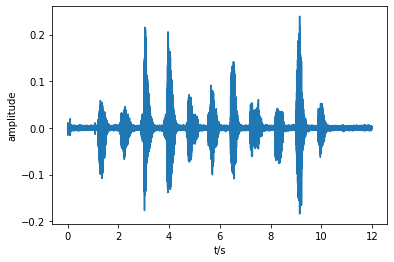

<Figure size 432x288 with 0 Axes>

In [15]:
dial = ak.read_Audio("sample_audio/dial(Chinese).wav")
dial.plot()

To perform endpoint detection for speech signal, calculate short-time zero crossing rate and short-time energy.

In [16]:
dial_framed = dial.framing(window="hamming")

<AxesSubplot:>

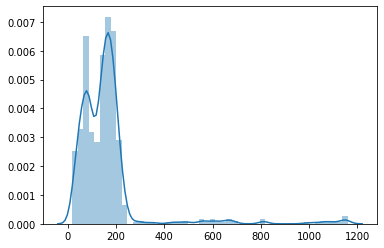

In [17]:
sns.distplot(aly.zerocrossing(dial_framed).samples)

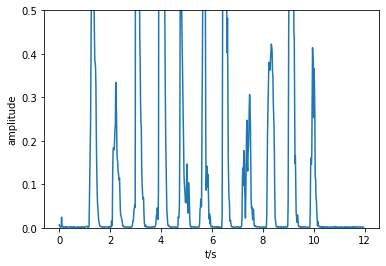

<Figure size 432x288 with 0 Axes>

In [18]:
aly.energy(dial_framed).plot(ylim=(0,0.5))

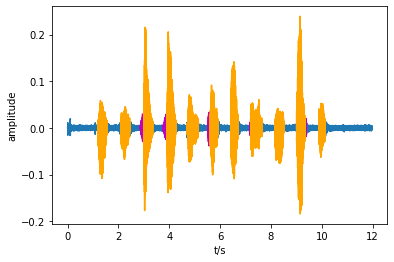

<Figure size 432x288 with 0 Axes>

In [19]:
vad_result_dial = alg.VAD(dial, 0.05, 0.2, 250)    #Conduct endpoint detection on the recording, set the lower short-term energy threshold to 0.05, the higher short-term energy threshold to 0.2, and the short-term zero crossing rate threshold to 250
vad_result_dial.plot()

The slices method of VAD object can extract all speech segments in the audio and return a list. We first extract the speech segments in the training set.

In [20]:
samples = vad_result.slices()
len(samples)

10

10 segments of speech are extracted, which correspond to the ten numbers 0-9 respectively.

Then extract the speech segments in the test set.

In [21]:
dials = vad_result_dial.slices()
len(dials)

12

The speech in the test set is an 11 digit phone number, but 12 segments of speech are extracted. So we look at the duration of each speech segment.

In [22]:
for d in dials:
    print(d.getDuration())

0.35975056689342405
0.3447392290249433
0.4796371882086168
0.5096145124716553
0.43467120181405894
0.38970521541950115
0.28478458049886624
0.49462585034013606
0.3297732426303855
0.329750566893424
0.014988662131519274
0.2548072562358277


We found that one segment of speech is significantly shorter than other speech, so we excluded this segment and get the speech corresponding to 11 numbers in the test set.

In [23]:
dials = [dial for dial in dials if dial.getDuration() > 0.1]
len(dials)

11

Next, we use MFCC+DTW for speech recognition. The default order of MFCC is 13. Let's try not to add difference and energy features first.

In [24]:
from pyAudioKits.algorithm import dtw

mfcc_samples = [aly.MFCC(sample,diff1=False,diff2=False,energy=False) for sample in samples]    #Using MFCC to extract the features of each speech segment on the training set
mfcc_dials = [aly.MFCC(dial,diff1=False,diff2=False,energy=False) for dial in dials]    #MFCC is used to extract the features of each speech in the test set
for dial in mfcc_dials: #Iterate over the test set
    distances = [dtw(dial, sample) for sample in mfcc_samples]  #Calculate the distance between the features of each segment of speech on the test set and the features of each segment of speech on the training set through DTW
    print(np.argmin(distances)) #The tag corresponding to the voice on the test set with the smallest DTW distance is the tag of the voice on the test set

1
5
3
3
0
9
8
7
1
2
5


It can be seen that all the results are correct except that the "2" in the seventh position is recognized as "8".

Next, try to add difference and energy features.

In [25]:
mfcc_samples = [aly.MFCC(sample,diff1=True,diff2=True,energy=True) for sample in samples]
mfcc_dials = [aly.MFCC(dial,diff1=True,diff2=True,energy=True) for dial in dials]
for dial in mfcc_dials:
    distances = [dtw(dial, sample) for sample in mfcc_samples]
    print(np.argmin(distances))

1
5
3
3
0
9
8
0
1
2
5


On the contrary, the recognition accuracy decreases, which shows that adding more features does not necessarily increase the recognition accuracy.

Since we just recorded one training set audio, there is only one audio sample of the ten numbers 0-9 respectively in the training set. Next, we read more samples and perform the same endpoint detection and MFCC feature extraction operations.

In [26]:
samples2 = ak.read_Audio("sample_audio/zero_to_nine2(Chinese).wav")
samples3 = ak.read_Audio("sample_audio/zero_to_nine3(Chinese).wav")
vad_result_samples2 = alg.VAD(samples2, 0.05, 0.2, 300)
vad_result_samples3 = alg.VAD(samples3, 0.05, 0.2, 300)
samples2 = vad_result_samples2.slices()
samples3 = vad_result_samples3.slices()
mfcc_samples2 = [aly.MFCC(sample,diff1=True,diff2=True,energy=True) for sample in samples2]
mfcc_samples3 = [aly.MFCC(sample,diff1=True,diff2=True,energy=True) for sample in samples3]

In this way, the training set is expanded to three times the original. Calculate the distance between each speech segment on the test set and each segment on the three training sets, and take the label corresponding to the speech on the training set with the smallest distance. In this way, each speech segment in the test set will get 3 labels. 

In [27]:
result = [[] for i in range(len(mfcc_dials))]
for i,dial in enumerate(mfcc_dials):
    distances = [dtw(dial, sample) for sample in mfcc_samples]
    result[i].append(np.argmin(distances))
    distances = [dtw(dial, sample) for sample in mfcc_samples2]
    result[i].append(np.argmin(distances))
    distances = [dtw(dial, sample) for sample in mfcc_samples3]
    result[i].append(np.argmin(distances))

In [28]:
result

[[1, 1, 1],
 [5, 5, 5],
 [3, 3, 3],
 [3, 3, 3],
 [0, 0, 0],
 [9, 9, 9],
 [8, 2, 8],
 [0, 7, 7],
 [1, 1, 1],
 [2, 2, 2],
 [5, 5, 5]]

As we can see, more than half of the training sets have given the eighth position the label "7", so we can determine that the eighth digit is "7". The seventh digit "2" is still difficult to distinguish, but there is already a segment of speech on training set gives it the "2" label. If we continue to expand the training set, the accuracy rate will continue to improve. However, the speed of matching using the DTW algorithm will decrease. 